In [88]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import numpy as np
from skimage.io import imread
from skimage.transform import resize

# Ścieżki do danych
images_dir = "C:/Users/Malak/Downloads/guz/Brain Tumor/Brain Tumor"
csv_file = "C:/Users/Malak/Downloads/guz/Brain Tumor.csv"

# Wczytanie danych tablicowych
data = pd.read_csv(csv_file)

# Funkcja do wczytywania i przetwarzania obrazów
def process_image(file_name):
    file_path = os.path.join(images_dir, file_name + '.jpg')
    image = imread(file_path, as_gray=True)  # Wczytanie obrazu w skali szarości
    #image = resize(image, (224, 224))  # Upewnienie się, że obraz ma wymiary 240x240
    image = image / 255.0  # Normalizacja do zakresu [0, 1]
    return image.reshape(240, 240, 1)  # Dodanie wymiaru kanału

# Przetwarzanie obrazów
data['processed_image'] = data['Image'].apply(process_image)

# Przygotowanie danych tablicowych - normalizacja
# Zakładamy, że dane są już w odpowiedniej formie i nie wymagają dodatkowego przetwarzania
# Można dodać tutaj normalizację danych tablicowych jeśli to konieczne

# Podział danych na treningowe, walidacyjne i testowe
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

# Przygotowanie zestawów danych
X_train = np.array(train_data['processed_image'].tolist())
X_val = np.array(val_data['processed_image'].tolist())
X_test = np.array(test_data['processed_image'].tolist())

# Kategorie
y_train = train_data['Class'].values
y_val = val_data['Class'].values
y_test = test_data['Class'].values


In [152]:
import tensorflow as tf
from tensorflow.keras import layers, models, Model
import numpy as np
import matplotlib.pyplot as plt

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.002,
    decay_steps=20,
    decay_rate=0.99,
    staircase=True)


def create_vit_model(input_shape, patch_size, num_layers, d_model, num_heads, mlp_dim, num_classes):
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    inputs = layers.Input(shape=input_shape)
    
    # Patch and Position Embedding
    patches = layers.Conv2D(filters=d_model, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
    patches = layers.Reshape(target_shape=(num_patches, d_model))(patches)
    position_embedding = layers.Embedding(input_dim=num_patches, output_dim=d_model, trainable=True)
    positions = tf.range(start=0, limit=num_patches, delta=1)
    encoded_patches = patches + position_embedding(positions)
    
    # Transformer Encoder Layers
    for _ in range(num_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # MultiHead Attention
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model, dropout=0.1)(x1, x1)
        # Skip connection
        x2 = layers.Add()([attention_output, x1])
        # Layer normalization 2
        x2 = layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP
        x3 = layers.Dense(mlp_dim, activation=tf.nn.gelu)(x2)
        x3 = layers.Dropout(0.1)(x3)  # Adding dropout
        mlp_output = layers.Dense(d_model)(x3)
        # Skip connection
        encoded_patches = layers.Add()([mlp_output, x2])
    
    # Global average pooling
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.GlobalAveragePooling1D()(representation)
    representation = layers.Dropout(0.1)(representation)
    
    # Classification head
    logits = layers.Dense(mlp_dim, activation=tf.nn.gelu)(representation)
    #logits = layers.Dense(num_classes)(logits)
    outputs = layers.Activation('sigmoid')(logits)
    
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule, beta_1=0.6), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Parametry modelu
input_shape = (240, 240, 1)
patch_size = 20
num_layers = 2
d_model = 32
num_heads = 4
mlp_dim = 60
num_classes = 1  # Przykład dla klasyfikacji binarnej

# Utworzenie modelu
model = create_vit_with_cam(input_shape, patch_size, num_layers, d_model, num_heads, mlp_dim, num_classes)
#model.summary()

In [153]:
from tensorflow.keras.callbacks import EarlyStopping

# Definicja funkcji zwrotnej EarlyStopping
early_stopper = EarlyStopping(monitor='val_loss', patience=16, verbose=1, restore_best_weights=True)


# Użycie funkcji do trenowania modelu
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=32, callbacks=[early_stopper])

Epoch 1/50
71/71 [==============================] - 6s 29ms/step - loss: 0.6789 - accuracy: 0.5727 - val_loss: 0.5678 - val_accuracy: 0.7291
Epoch 2/50
71/71 [==============================] - 2s 21ms/step - loss: 0.5493 - accuracy: 0.7340 - val_loss: 0.5228 - val_accuracy: 0.7663
Epoch 3/50
71/71 [==============================] - 2s 22ms/step - loss: 0.4991 - accuracy: 0.7691 - val_loss: 0.4721 - val_accuracy: 0.8035
Epoch 4/50
71/71 [==============================] - 2s 21ms/step - loss: 0.4415 - accuracy: 0.8067 - val_loss: 0.4137 - val_accuracy: 0.8127
Epoch 5/50
71/71 [==============================] - 1s 21ms/step - loss: 0.4017 - accuracy: 0.8320 - val_loss: 0.3605 - val_accuracy: 0.8606
Epoch 6/50
71/71 [==============================] - 2s 22ms/step - loss: 0.3878 - accuracy: 0.8342 - val_loss: 0.3656 - val_accuracy: 0.8539
Epoch 7/50
71/71 [==============================] - 2s 22ms/step - loss: 0.3623 - accuracy: 0.8488 - val_loss: 0.3791 - val_accuracy: 0.8340
Epoch 8/50
71

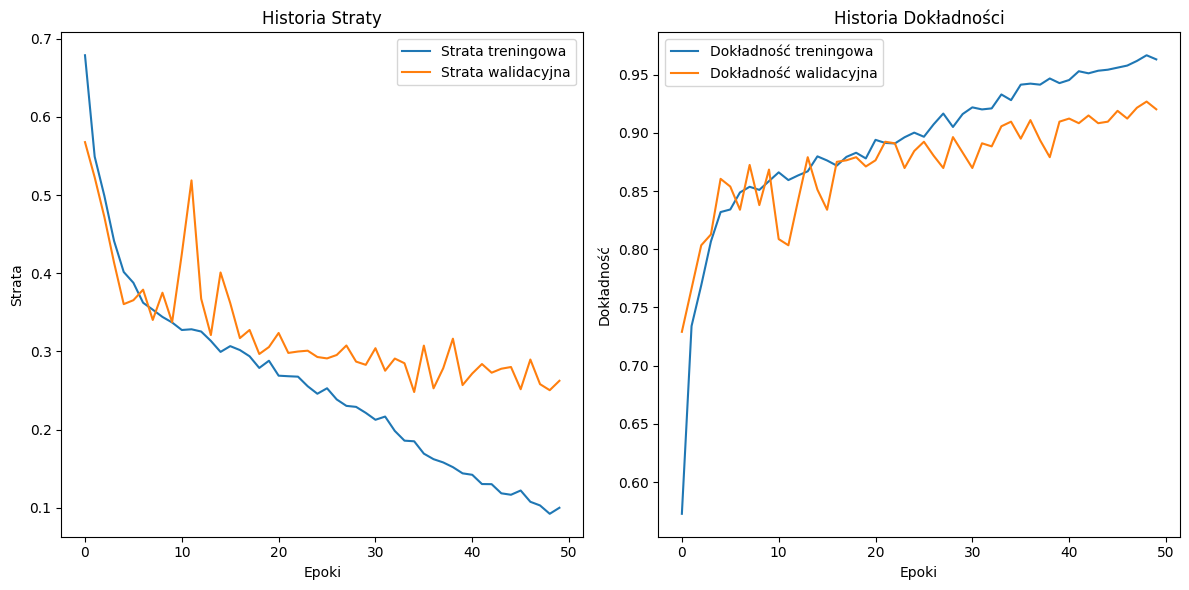

In [154]:
import matplotlib.pyplot as plt

# Wizualizacja historii treningu
plt.figure(figsize=(12, 6))

# Wizualizacja straty
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Strata treningowa')
plt.plot(history.history['val_loss'], label='Strata walidacyjna')
plt.title('Historia Straty')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

# Wizualizacja dokładności
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Dokładność treningowa')
plt.plot(history.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Historia Dokładności')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()

plt.tight_layout()
plt.show()

In [155]:
# Ocena modelu na danych testowych
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print(f'Testowa strata: {test_loss:.4f}')
print(f'Testowa dokładność: {test_accuracy:.4f}')

24/24 [==============================] - 0s 9ms/step - loss: 0.2465 - accuracy: 0.9177
Testowa strata: 0.2465
Testowa dokładność: 0.9177


In [151]:
from tensorflow.math import confusion_matrix
import numpy as np

# Załóżmy, że 'y_test' zawiera prawdziwe etykiety, a 'X_test' to dane testowe.
# Przewidywania modelu jako binarne klasyfikacje (0 lub 1)
predictions = model.predict(X_test)
predictions = np.round(predictions).astype(int)  # Przewidywania jako 0 lub 1

# Rzeczywiste etykiety powinny być również w formacie 0 lub 1
y_true = y_test.astype(int)

# Obliczenie macierzy pomyłek
cm = confusion_matrix(y_true, predictions)

# Wyodrębnienie wartości z macierzy pomyłek
TN, FP, FN, TP = cm.numpy().ravel()

# Obliczenie metryk
total = TN + FP + FN + TP
accuracy = (TP + TN) / total
precision = TP / (TP + FP)
recall = TP / (TP + FN)
specificity = TN / (TN + FP)

# Wyświetlenie wyników
print(f"Na prawde ma (prawdziwie pozytywne): {TP/total*100:.2f}%")
print(f"Na prawde nie ma guza (prawdziwie negatywne): {TN/total*100:.2f}%")
print(f"Ma guza, ale to kłamstwo (fałszywie pozytywne): {FP/total*100:.2f}%")
print(f"Nie ma guza, a tak na prawde ma (fałszywie negatywne): {FN/total*100:.2f}%")

24/24 [==============================] - 1s 8ms/step
Na prawde ma (prawdziwie pozytywne): 40.37%
Na prawde nie ma guza (prawdziwie negatywne): 49.40%
Ma guza, ale to kłamstwo (fałszywie pozytywne): 6.24%
Nie ma guza, a tak na prawde ma (fałszywie negatywne): 3.98%
